In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc


import warnings
warnings.filterwarnings("ignore")

### Part 1 Load Data

In [2]:
fraud_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Fraud/Fraud_Data.csv')
ip_address_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Fraud/IpAddress_to_Country.csv')

In [3]:
fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


In [4]:
ip_address_data.head(3)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China


In [5]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [6]:
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])

In [7]:
for column in fraud_data.columns:
    uniques = fraud_data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              151112	 [ 22058 333320   1359 150084 221365]
signup_time          151112	 ['2015-02-24T22:55:49.000000000' '2015-06-07T20:39:50.000000000'
 '2015-01-01T18:52:44.000000000' '2015-04-28T21:13:25.000000000'
 '2015-07-21T07:09:52.000000000']
purchase_time        150679	 ['2015-04-18T02:47:11.000000000' '2015-06-08T01:38:54.000000000'
 '2015-01-01T18:52:45.000000000' '2015-05-04T13:54:50.000000000'
 '2015-09-09T18:40:53.000000000']
purchase_value         122	 [34 16 15 44 39]
device_id            137956	 ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ' 'ATGTXKYKUDUQN'
 'NAUITBZFJKHWW']
source                   3	 ['SEO' 'Ads' 'Direct']
browser                  5	 ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
sex                      2	 ['M' 'F']
age                     58	 [39 53 41 45 18]
ip_address           143512	 [7.32758369e+08 3.50311388e+08 2.62147382e+09 3.84054244e+09
 4.15583117e+08]
class                    2	 [0 1]


In [8]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [9]:
ip_address_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [10]:
ip_address_data.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


We notice that the range of ip_address in the ip_address_data [1.677722e+07, 3.758096e+09] is much narrow than that in fraud data [5.209350e+04, 4.294850e+09] , therefore we should expect there are some records leaving the variable of country as NA after merge.

In [11]:
countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    tmp = ip_address_data[(ip_address_data['lower_bound_ip_address'] <= ip_address) &
                          (ip_address_data['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('not_found')
        
fraud_data['country'] = countries

fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


## Part 2 Data visualization

### 1. Fraud vs time variables

#### 1.1) Fraud vs time difference

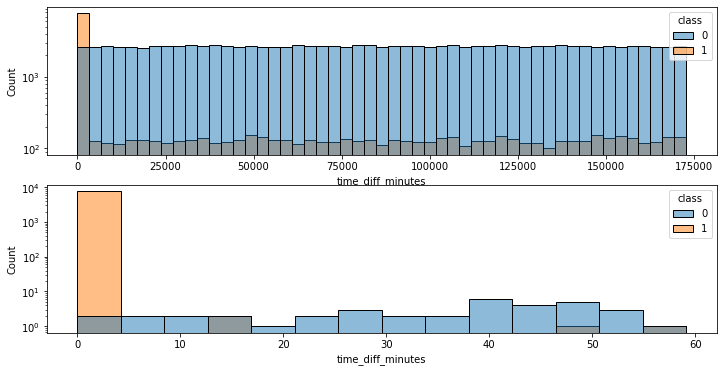

In [12]:
fraud_data['time_diff_minutes'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()/60
fraud_data['time_diff_seconds'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()

fig, ax = plt.subplots(2, 1, figsize = (12, 6))

sns.histplot(data = fraud_data, x = 'time_diff_minutes', hue = 'class', ax = ax[0])
sns.histplot(data = fraud_data[fraud_data['time_diff_minutes'] < 60], x = 'time_diff_minutes', hue = 'class', ax = ax[1])

ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

The bar plot above shows that most of the account with fraud tend to make the purchase right after creating the fraud account. Therefore, it the time difference between register and purchase can be taken as an important fraud signal.

##### 1.2) Fraud vs day_of_week

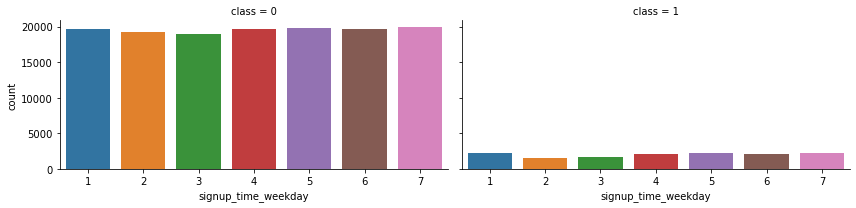

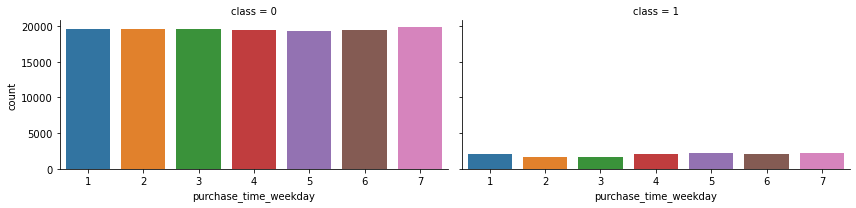

In [13]:
fraud_data['purchase_time_weekday'] = fraud_data['purchase_time'].dt.dayofweek+1
fraud_data['signup_time_weekday'] = fraud_data['signup_time'].dt.dayofweek+1

sns.catplot(data = fraud_data, 
            x = 'signup_time_weekday', col = 'class', kind = 'count',  height = 3, aspect = 2)
sns.catplot(data = fraud_data, 
            x = 'purchase_time_weekday', col = 'class',kind = 'count', height = 3, aspect = 2)
plt.show()

The two plots above show that the sign up and purchase of fraud account are relatively low in Tuesday and Wednesday. While for none fraud accounts, the distribution between different weekdays are not so obvious.

##### 1.3) Fraud vs week_num

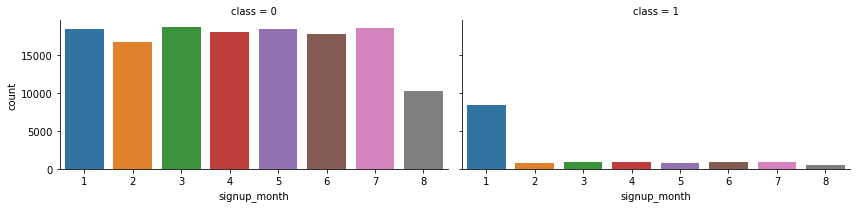

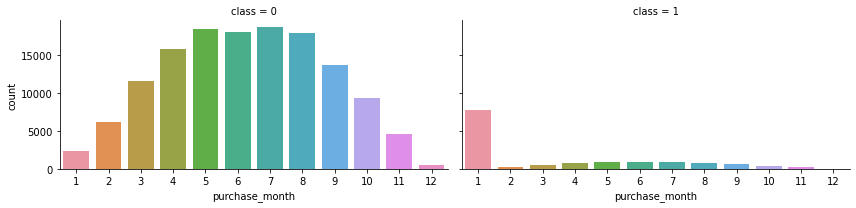

In [14]:
fraud_data['purchase_month'] = fraud_data['purchase_time'].dt.month
fraud_data['signup_month'] = fraud_data['signup_time'].dt.month

sns.catplot(data = fraud_data, x = 'signup_month', col = 'class', kind = 'count', height = 3, aspect = 2)
sns.catplot(data = fraud_data, x = 'purchase_month', col = 'class', kind = 'count',  height = 3, aspect = 2)
plt.show()

The interesting phenomenon of the distribution of month between class 0 and 1 is that:
   1) Non-fraud accounts are created randomly in every month, and their purchase reached the peak season in June, July and August.
   2) Fraud accounts are registered in January mostly.

### 2 Fraud vs purchase value

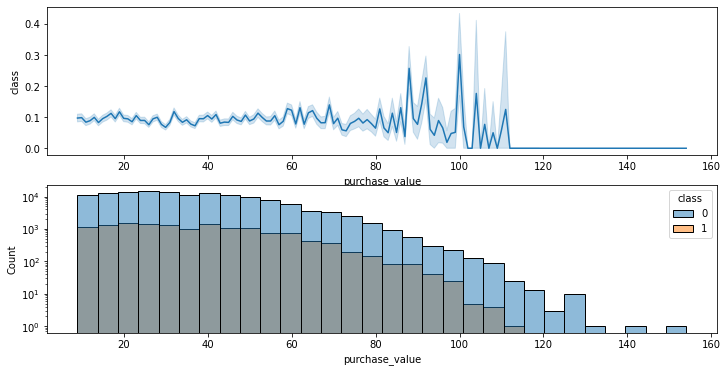

In [15]:
fig, ax = plt.subplots(2, 1 ,figsize = (12, 6))

sns.lineplot(data = fraud_data, x = 'purchase_value', y = 'class', estimator = 'mean', ax = ax[0])
sns.histplot(data = fraud_data, x = 'purchase_value', hue = 'class', bins = 30, ax = ax[1])
ax[1].set_yscale("log")

plt.show()

The two plots above shows that:
      1) The possibility of fraud account when the purchase amount in the range of [80, 100] is especially high.
      2) Both non-fraud account and fraud account have lots of purchase with the amount in range [0, 60] 

### 3. Fraud vs customer source

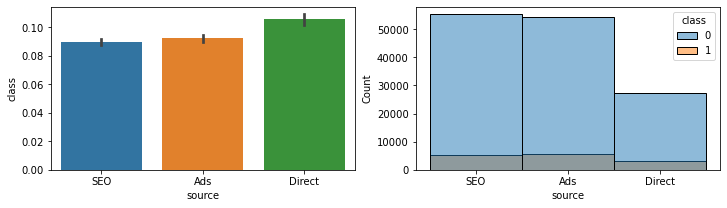

In [16]:
fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = fraud_data, x = 'source', y = 'class', estimator = np.mean, ax = ax[0])
sns.histplot(data = fraud_data, x = 'source', hue = 'class', ax = ax[1])

plt.show()

The two plots above indicate that the fraud rate of Direct source is higher than the other two sources. However, it's obvious that Ads and SEO are still the main source of purchase for non-fraud users. This emphases the possibility of Fraud for users from "Direct' source.

### 4. Fraud vs browser

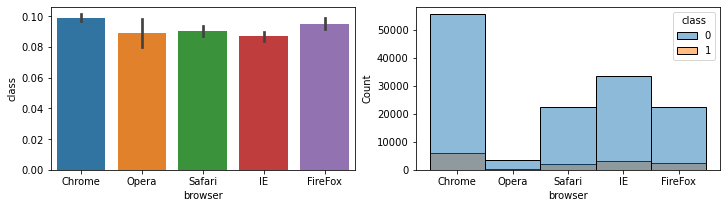

In [17]:
fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = fraud_data, x = 'browser', y = 'class', estimator = np.mean, ax = ax[0])
sns.histplot(data = fraud_data, x = 'browser', hue = 'class', ax = ax[1])

plt.show()

There is no significant difference in fraud rate between the five browser types.

### 5. Fraud vs sex

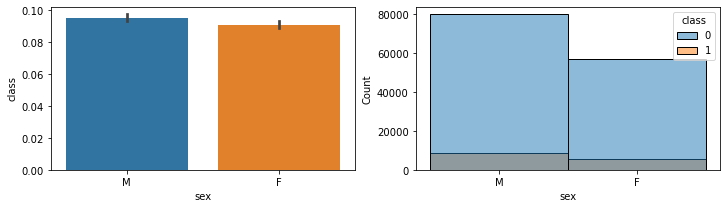

In [18]:
fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = fraud_data, x = 'sex', y = 'class', estimator = np.mean, ax = ax[0])
sns.histplot(data = fraud_data, x = 'sex', hue = 'class', ax = ax[1])

plt.show()

There is no significant difference in fraud rate between female and male.

### 6. Fraud vs age

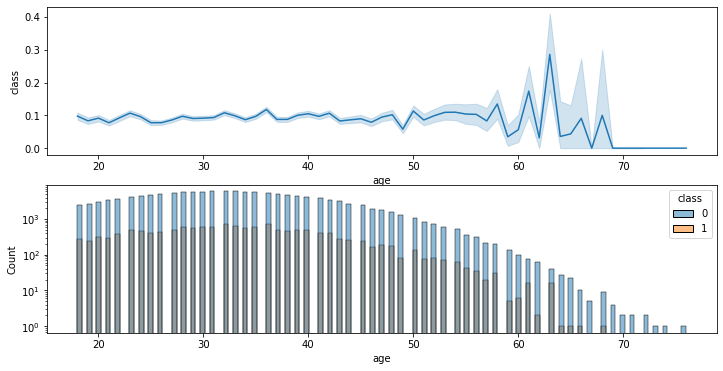

In [19]:
fig, ax = plt.subplots(2, 1 ,figsize = (12, 6))

sns.lineplot(data = fraud_data, x = 'age', y = 'class', estimator = np.mean, ax = ax[0])
sns.histplot(data = fraud_data, x = 'age', ax = ax[1], hue = 'class')
ax[1].set_yscale("log")

plt.show()

Users in the age range of [60, 65] are more likely to take fraud purchase.
While the general age group of customer in both non-fraud and fraud accounts is [25, 40]

### 7. Fraud vs country

In [20]:
country_fraud_count = fraud_data[['country', 'class']].groupby(
                      'country').count().sort_values(by = 'class', ascending = False).iloc[ :10, :].reset_index()
country_fraud_rate = fraud_data[['country', 'class']].groupby(
                      'country').mean().sort_values(by = 'class', ascending = False).iloc[ :10, :].reset_index()
country_fraud = pd.concat([country_fraud_count,country_fraud_rate], axis = 1).reset_index()
country_fraud.iloc[:, 1:]

,country,class,country,class
0,United States,58049,Turkmenistan,1.000000
1,not_found,21966,Namibia,0.434783
2,China,12038,Sri Lanka,0.419355
3,Japan,7306,Luxembourg,0.388889
4,United Kingdom,4490,Virgin Islands (U.S.),0.333333
5,Korea Republic of,4162,Ecuador,0.264151
6,Germany,3646,Tunisia,0.262712
7,France,3161,Peru,0.260504
8,Canada,2975,Bolivia,0.245283
9,Brazil,2961,Kuwait,0.233333


The pivot table above shows that countries including Turkmenistan, Namibia, Sri Lanka, Luxembourg and Virgin Islands (U.S.) have absolutely high level of fraud.  But the customer base of these countries as also very low.

Countries including US, China and Japan have a large number of fraud accounts, but their customer base are also high.

### 8. Fraud vs shared device/ ip_address

In [21]:
# First calculate the number of user sharing the same device
device_count = fraud_data[['device_id', 'user_id']].groupby(['device_id'])['user_id'].count().reset_index()
device_count.columns = ['device_id', 'users_shared_one_device']
# Then calculate the fraud rate for each device
device_rate = fraud_data[['device_id', 'class']].groupby(['device_id'])['class'].mean().reset_index()
device_rate.columns = ['device_id', 'fraud_rate']

temp_device = pd.merge(left = device_count, right = device_rate, 
                how = 'left', left_on = 'device_id', right_on = 'device_id' )

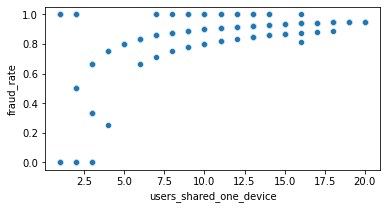

In [22]:
fig, ax = plt.subplots(figsize = (6, 3))
sns.scatterplot(data = temp_device, x = 'users_shared_one_device', y = 'fraud_rate')

plt.show()

In [23]:
# First calculate the number of user sharing the same ip_address
ip_count = fraud_data[['ip_address', 'user_id']].groupby(['ip_address'])['user_id'].count().reset_index()
ip_count.columns = ['ip_address', 'users_shared_one_IP']
# Then calculate the fraud rate for each ip_address
ip_rate = fraud_data[['ip_address', 'class']].groupby(['ip_address'])['class'].mean().reset_index()
ip_rate.columns = ['ip_address', 'fraud_rate']

temp_ip = pd.merge(left = ip_count, right = ip_rate, 
                how = 'left', left_on = 'ip_address', right_on = 'ip_address' )

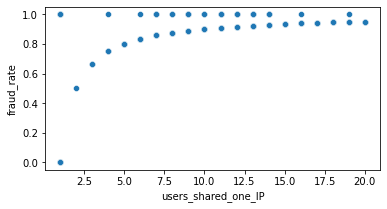

In [24]:
fig, ax = plt.subplots(figsize = (6, 3))
sns.scatterplot(data = temp_ip, x = 'users_shared_one_IP', y = 'fraud_rate')

plt.show()

From this plot we notice that the more account share the same device or ip_address, the more likely they are fraud accounts

In [25]:
merged_data = pd.merge(left = fraud_data, right = temp_ip.iloc[:,:2], 
                how = 'left', left_on = 'ip_address', right_on = 'ip_address' )
merged_data = pd.merge(left = merged_data, right = temp_device.iloc[:,:2], 
                how = 'left', left_on = 'device_id', right_on = 'device_id' )
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff_minutes,time_diff_seconds,purchase_time_weekday,signup_time_weekday,purchase_month,signup_month,users_shared_one_IP,users_shared_one_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,75111.366667,4506682.0,6,2,4,2,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,299.066667,17944.0,1,7,6,6,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0.016667,1.0,4,4,1,1,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,not_found,8201.416667,492085.0,1,2,5,4,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,72691.016667,4361461.0,3,2,9,7,1,1


## Part 3. Model fitting

Based on the visualization part, we have already figure out some important features which have high correlations with the fraud activities.

Consider there are too many category variables, it's better to adopt tree_based models.

Here we use the random forest to fit the model

In [26]:
merged_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'time_diff_minutes', 'time_diff_seconds',
       'purchase_time_weekday', 'signup_time_weekday', 'purchase_month',
       'signup_month', 'users_shared_one_IP', 'users_shared_one_device'],
      dtype='object')

In [27]:
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 
       'country', 'time_diff_minutes', 'purchase_time_weekday', 'signup_time_weekday', 'purchase_month',
       'signup_month', 'users_shared_one_IP', 'users_shared_one_device']

X_train = pd.get_dummies(merged_data[features], 
                         columns = ['source', 'browser', 'sex', 'country', 'purchase_time_weekday', 
                                    'signup_time_weekday', 'purchase_month', 'signup_month'], drop_first = False)
y_train = merged_data['class']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1)

In [29]:
rf_reg = RandomForestClassifier(max_features = 8)
rf_reg.fit(X_train, y_train)

RandomForestClassifier(max_features=8)

In [30]:
model = rf_reg
train_con_matrix = confusion_matrix(y_train, model.predict(X_train))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test)), 4))

train matrix: 
 [[109609      0]
 [     6  11274]]
train accuracy: 1.0

 test matrix: 
 [[27346     6]
 [ 1327  1544]]
test accuracy: 0.9559


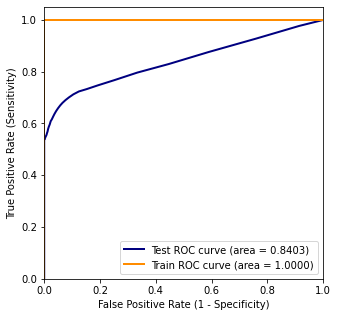

In [31]:
y_test_pred_prob = model.predict_proba(X_test)[:,1]
y_train_pred_prob = model.predict_proba(X_train)[:,1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=[5, 5])

plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='Test ROC curve (area = %0.4f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.4f)' % roc_auc_train)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

In [32]:
rf_reg_importances = pd.DataFrame(rf_reg.feature_importances_, index = X_test.columns)

rf_reg_importances.columns = ['importance']
rf_reg_importances.sort_values(by = 'importance', ascending = False)[:10]

,importance
time_diff_minutes,0.214141
users_shared_one_device,0.151743
users_shared_one_IP,0.109155
purchase_month_1,0.072561
purchase_value,0.061731
age,0.057616
signup_month_1,0.025899
country_United States,0.009649
browser_Chrome,0.008851
signup_time_weekday_6,0.008171


Feature importance above displayed the top 10 features which will decide the new user is a fraud account or not. They align with the findings we discovered in Part 2 Data Visualization.